In [135]:
import numpy as np  
import pandas as pd  
from catboost import CatBoostClassifier  
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict  
from sklearn.metrics import classification_report  
import shap  
import matplotlib.pyplot as plt 

In [137]:
data = pd.read_excel('Dataset.xlsx', sheet_name='ARDS Phase 01 fb(T1 & T2)')

In [139]:
# Reset index so that CV partitions work without index duplication issues  
df = df.reset_index(drop=True)

In [141]:
# Set random seed  
random_state = 42

In [143]:
# Check for required columns  
required_cols = ['Label', 'Fi02_T2', 'mode _T2']  
for col in required_cols:  
    if col not in df.columns:  
        raise ValueError('Column ' + col + ' not found in dataframe')  

In [145]:
# Prepare features: significant and all features (dropping 'Label')  
significant_features = ['Fi02_T2', 'mode _T2']  
X_sig = df[significant_features]  
X_all = df.drop(columns=['Label'])  
y = df['Label'] 

In [147]:
# Verify the label distribution and dataset shape  
print("Dataset shape after reset:", df.shape)  
print("Label distribution:")  
print(df['Label'].value_counts())  
print("Total missing values in dataset:", df.isnull().sum().sum())

Dataset shape after reset: (95, 54)
Label distribution:
Label
0    48
1    47
Name: count, dtype: int64
Total missing values in dataset: 2


In [149]:
# Define CV scheme: repeated stratified 10-fold CV (10 repeats)  
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

In [173]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
import numpy as np

def run_classification(X, y, descriptor):
    print("Running classification for: " + descriptor)
    model = CatBoostClassifier(verbose=0, random_state=random_state)
    tscv = TimeSeriesSplit(n_splits=5)  # Ensure this matches your CV setup
    predictions = np.full(y.shape[0], fill_value=np.nan)  # Initialize with NaNs
    
    for train_idx, test_idx in tscv.split(X):
        # Clone model for each fold to prevent leakage
        split_model = clone(model)
        split_model.fit(X.iloc[train_idx], y.iloc[train_idx])
        fold_preds = split_model.predict(X.iloc[test_idx])
        predictions[test_idx] = fold_preds  # Assign to correct indices
    
    # Handle any remaining NaNs (if splits don't cover all data)
    valid_mask = ~np.isnan(predictions)
    y_filtered = y[valid_mask]
    preds_filtered = predictions[valid_mask].astype(int)
    
    report = classification_report(y_filtered, preds_filtered, output_dict=True)
    print(f"Classification Report for {descriptor}:")
    print(classification_report(y_filtered, preds_filtered))
    return model, report


In [175]:
# Run classification for significant features
print("--- Classification using significant features only ---")
model_sig, report_sig = run_classification(X_sig, y, 'Significant Features')

--- Classification using significant features only ---
Running classification for: Significant Features
Classification Report for Significant Features:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        36
           1       0.76      0.72      0.74        39

    accuracy                           0.73        75
   macro avg       0.73      0.73      0.73        75
weighted avg       0.73      0.73      0.73        75



In [177]:
# Classification with all features  
print("\n--- Classification using all features ---")  
model_all, report_all = run_classification(X_all, y, 'All Features') 


--- Classification using all features ---
Running classification for: All Features
Classification Report for All Features:
              precision    recall  f1-score   support

           0       0.55      0.78      0.64        36
           1       0.67      0.41      0.51        39

    accuracy                           0.59        75
   macro avg       0.61      0.59      0.58        75
weighted avg       0.61      0.59      0.57        75



In [187]:
from catboost import Pool  # Add this import

def compute_shap(model, X, descriptor):
    # Convert DataFrame to CatBoost Pool
    data_pool = Pool(X, label=y)  # Explicitly create a Pool
    
    # Fit the model on the Pool (or original data - both work)
    model.fit(X, y, verbose=0)  # X can stay as DataFrame here
    
    # Get SHAP values using the Pool
    shap_values = model.get_feature_importance(data=data_pool, type='ShapValues')
    shap_values = shap_values[:, 1:]  # Remove base value column
    
    print("SHAP values computed for " + descriptor)
    return shap_values


In [189]:
print("\n--- SHAP analysis for significant features ---")
model_sig_full = CatBoostClassifier(verbose=0, random_state=random_state)
shap_values_sig = compute_shap(model_sig_full, X_sig, 'Significant Features')



--- SHAP analysis for significant features ---
SHAP values computed for Significant Features


In [191]:
print("\n--- SHAP analysis for all features ---")  
model_all_full = CatBoostClassifier(verbose=0, random_state=random_state)  
shap_values_all = compute_shap(model_all_full, X_all, 'All Features')


--- SHAP analysis for all features ---
SHAP values computed for All Features



Plotting SHAP beeswarm for significant features:


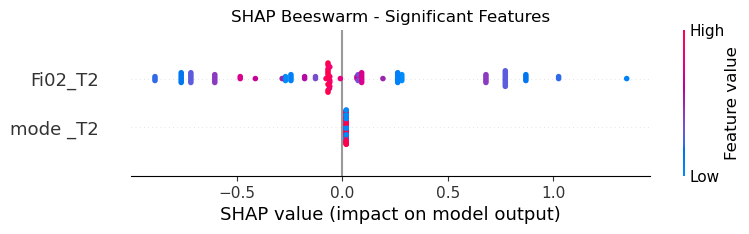

In [197]:
# Plot beeswarm plots for SHAP values for both cases  
print("\nPlotting SHAP beeswarm for significant features:")  
shap.initjs()  
plt.figure()  
shap.summary_plot(shap_values_sig, X_sig, plot_type='dot', show=False)  
plt.title('SHAP Beeswarm - Significant Features')  
plt.show()  


Plotting SHAP beeswarm for all features:


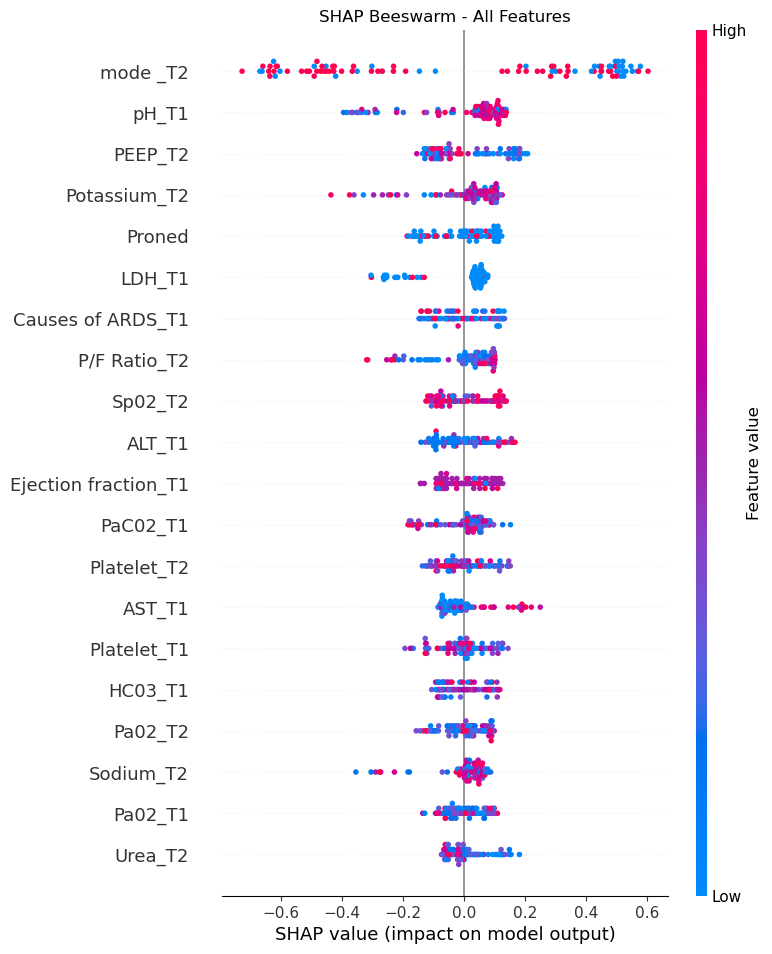

In [195]:
print("\nPlotting SHAP beeswarm for all features:")  
plt.figure()  
shap.summary_plot(shap_values_all, X_all, plot_type='dot', show=False)  
plt.title('SHAP Beeswarm - All Features')  
plt.show()